# Pangeo Quadratic Means Workload

This is a notebook for exploring the example in https://github.com/pangeo-data/distributed-array-examples/issues/2.

See also Tom Nicholas's [notebook](https://gist.github.com/TomNicholas/8366c917349b647d87860a20a257a3fb#file-benchmark-quadratic-ipynb) and Tom White's blog post, [Optimizing Cubed](https://medium.com/pangeo/optimizing-cubed-7a0b8f65f5b7).

In [1]:
import cubed
import cubed.random
from cubed.diagnostics.rich import RichProgressBar
import xarray as xr

Initialization parameters for the workload

In [2]:
t_length = 50
spec = cubed.Spec(allowed_mem="2GB")

Create random data stored in Zarr.

In [3]:
u = cubed.random.random((t_length, 1, 987, 1920), chunks=(10, 1, -1, -1), spec=spec)
v = cubed.random.random((t_length, 1, 987, 1920), chunks=(10, 1, -1, -1), spec=spec)
arrays = [u, v]
paths = [f"{spec.work_dir}/u_{t_length}.zarr", f"{spec.work_dir}/v_{t_length}.zarr"]
cubed.store(arrays, paths, compute_arrays_in_parallel=True, callbacks=[RichProgressBar()])

Output()

In [4]:
u = cubed.from_zarr(paths[0], spec=spec)
v = cubed.from_zarr(paths[1], spec=spec)
ds = xr.Dataset(
    dict(
        anom_u=(["time", "face", "j", "i"], u),
        anom_v=(["time", "face", "j", "i"], v),
    )
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 50, face: 1, j: 987, i: 1920)
Dimensions without coordinates: time, face, j, i
Data variables:
    anom_u   (time, face, j, i) float64 758MB cubed.Array<chunksize=(10, 1, 987, 1920)>
    anom_v   (time, face, j, i) float64 758MB cubed.Array<chunksize=(10, 1, 987, 1920)>

In [5]:
quad = ds**2
quad["uv"] = ds.anom_u * ds.anom_v
result = quad.mean("time", skipna=False)
result

<xarray.Dataset> Size: 45MB
Dimensions:  (face: 1, j: 987, i: 1920)
Dimensions without coordinates: face, j, i
Data variables:
    anom_u   (face, j, i) float64 15MB cubed.Array<chunksize=(1, 987, 1920)>
    anom_v   (face, j, i) float64 15MB cubed.Array<chunksize=(1, 987, 1920)>
    uv       (face, j, i) float64 15MB cubed.Array<chunksize=(1, 987, 1920)>

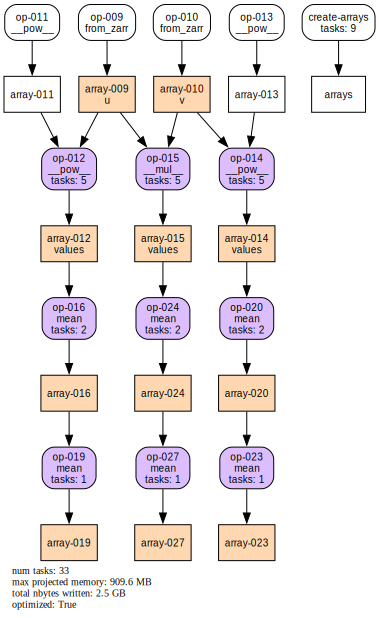

In [6]:
cubed.visualize(
    *(result[var].data for var in ("anom_u", "anom_v", "uv")),
)

In [7]:
result.compute(callbacks=[RichProgressBar()])

Output()

<xarray.Dataset> Size: 45MB
Dimensions:  (face: 1, j: 987, i: 1920)
Dimensions without coordinates: face, j, i
Data variables:
    anom_u   (face, j, i) float64 15MB 0.339 0.3298 0.3399 ... 0.3794 0.2628
    anom_v   (face, j, i) float64 15MB 0.3566 0.3384 0.3565 ... 0.3379 0.3464
    uv       (face, j, i) float64 15MB 0.2717 0.2679 0.281 ... 0.2727 0.2272